<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/GAN_Ising_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [53]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat

#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
labels = np.loadtxt('ising2_label.dat')

--2020-05-30 15:15:28--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.3’

ising2_conf.dat.3   100%[===================>]  18.18M   590KB/s    in 17s     

2020-05-30 15:15:45 (1.10 MB/s) - ‘ising2_conf.dat.3’ saved [19060775/19060775]

--2020-05-30 15:15:47--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.1’

ising2_label.dat.1  100%[===================>]  79.13K   141KB/s    in 0.6s    

2020-05-30 15:15:48 (141 KB/s) - ‘ising2_label.dat.1’ saved 

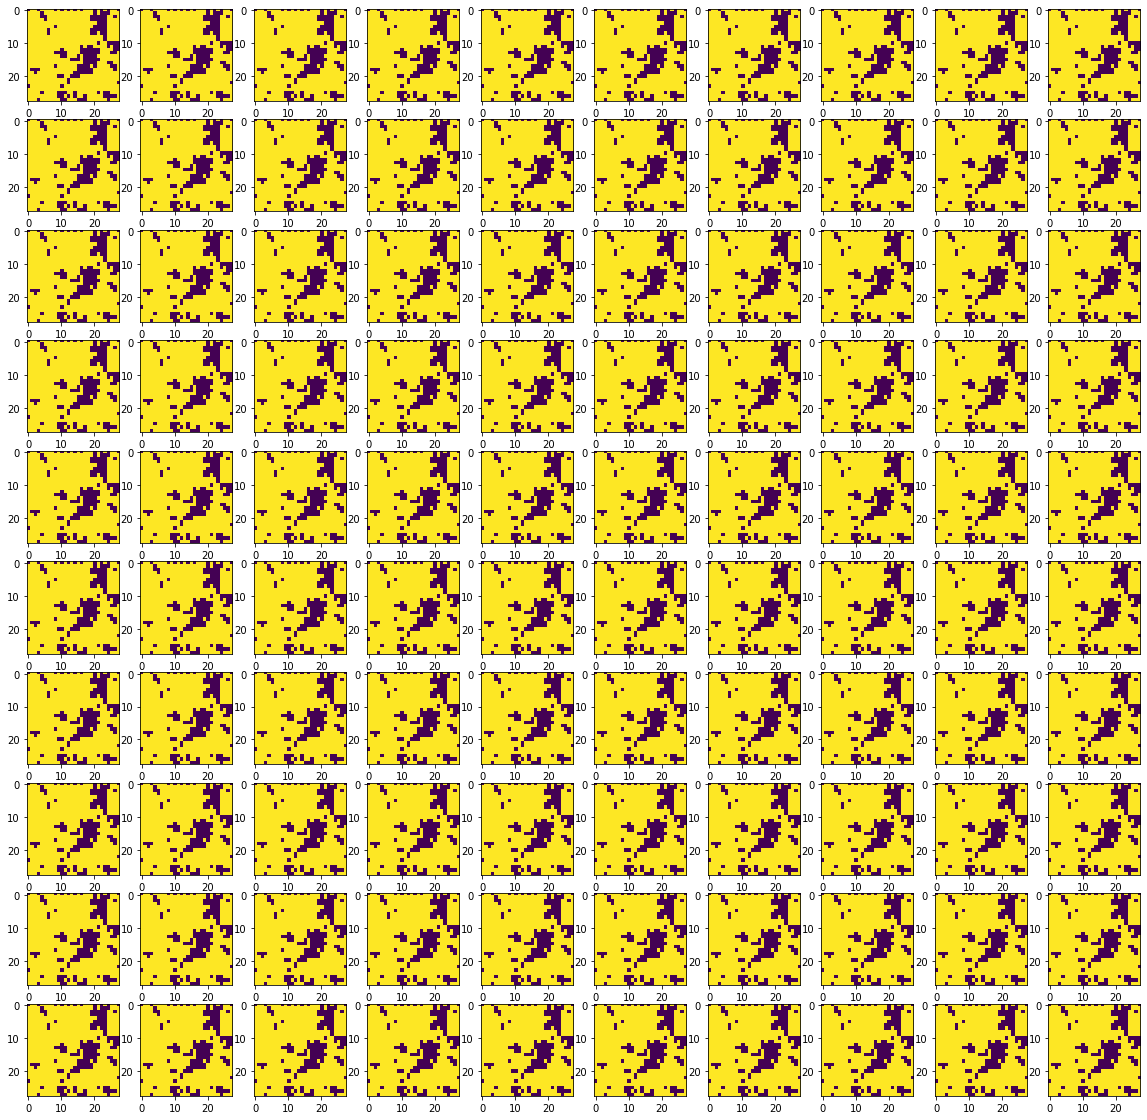

In [117]:
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(-1,28,28,1).astype('float32')

cri_sele = ((labels >= 2) & (labels <= 2.5))
cri_data = data[cri_sele]

n, m = 10, 10
fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(cri_data[n].reshape(28, 28))

train_dataset = tf.data.Dataset.from_tensor_slices(cri_data)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(32)

In [0]:
IMG_SHAPE = (28, 28, 1)

In [0]:
#definizione blocco convoluzionale + BN + Dropout
def conv_block(
  x, filters, activation, 
  kernel_size=(7, 7), strides=(1, 1), padding="same", 
  use_bias=True, use_bn=False, use_dropout=False, drop_value=0.5,
):
  x = layers.Conv2D(filters, kernel_size, strides=strides, 
                    padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

In [135]:
def get_discriminator_model():
  img_input = layers.Input(shape=IMG_SHAPE)
  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
    ], name='DataAugm')
  x = data_augmentation(img_input)
  # Zero pad the input to make the input images size to (32, 32, 1).
  x = layers.ZeroPadding2D((2, 2))(x)
  # BatchNorm OFF
  x = conv_block(img_input, 64, strides=(2, 2),
      use_bn=False, use_bias=True, activation=layers.LeakyReLU(0.2),
      use_dropout=True, drop_value=0.5)
  # BatchNorm ON - DropOut ON
  x = conv_block(x, 128, strides=(2, 2),
      use_bn=False, activation=layers.LeakyReLU(0.2),
      use_dropout=True, drop_value=0.5)
  x = layers.GlobalMaxPooling2D()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(1)(x)

  d_model = keras.models.Model(img_input, x, name="discriminator")
  return d_model

d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 64)        3200      
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 128)         401536    
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 7, 7, 128)       

In [136]:
# Generator: campiona un vettore latente e genera un immagine

# usa upsampling (Conv2DTranspose) per passare da z -> immagine
# Size of latent vector (la dimensione del vettore latente z)

latent_dim = 128

def get_generator_model():
    z = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 256)(z)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

    g_model = keras.models.Model(z, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 12544)             1618176   
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 14, 14, 128)       524416    
_________________________________________________________________
batch_normalization_61 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 14, 14, 128)       0 

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images = real_images[0]

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator(random_latent_vectors)
        #print(generated_images.shape, real_images.shape, flush=True)
        # 3) combina le immagini fake con quelle reali 
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4) assegna le label corrette (fae vs reale)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 5) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.2 * tf.random.uniform(tf.shape(labels))

        # 6) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(combined_images) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 7) campiona un nuovo batch di punti dello spazio latente: z
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.zeros((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors)) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

In [0]:
# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * self.norma

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img2 = keras.preprocessing.image.array_to_img(img)
            img2.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            img = img.reshape((28*28))
            np.savetxt("generated_img_{i}_{epoch}.dat".format(i=i, epoch=epoch), img)

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Epochs
EPOCHS = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=latent_dim, norma=255)

# Istanziamento modello
gan = DCGAN(discriminator=d_model, generator=g_model, latent_dim=latent_dim)

# Compilazione
gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=gan_loss,
)

In [139]:
# Start training
gan.fit(train_dataset, epochs=EPOCHS, callbacks=[cbk])

Epoch 1/20
16/16 [==============================] - 0s 20ms/step - d_loss: 0.5496 - g_loss: 0.8473
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4851 - g_loss: 0.8287
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4715 - g_loss: 0.7782
Epoch 4/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4687 - g_loss: 0.7626
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4586 - g_loss: 0.7874
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4346 - g_loss: 0.8414
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.4004 - g_loss: 0.9203
Epoch 8/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.3566 - g_loss: 1.0286
Epoch 9/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.3157 - g_loss: 1.1690
Epoch 10/20
16/16 [==============================] - 0s 17ms/step - d_loss: 0.2738 - g_loss: 1.3402
Epoch 11/

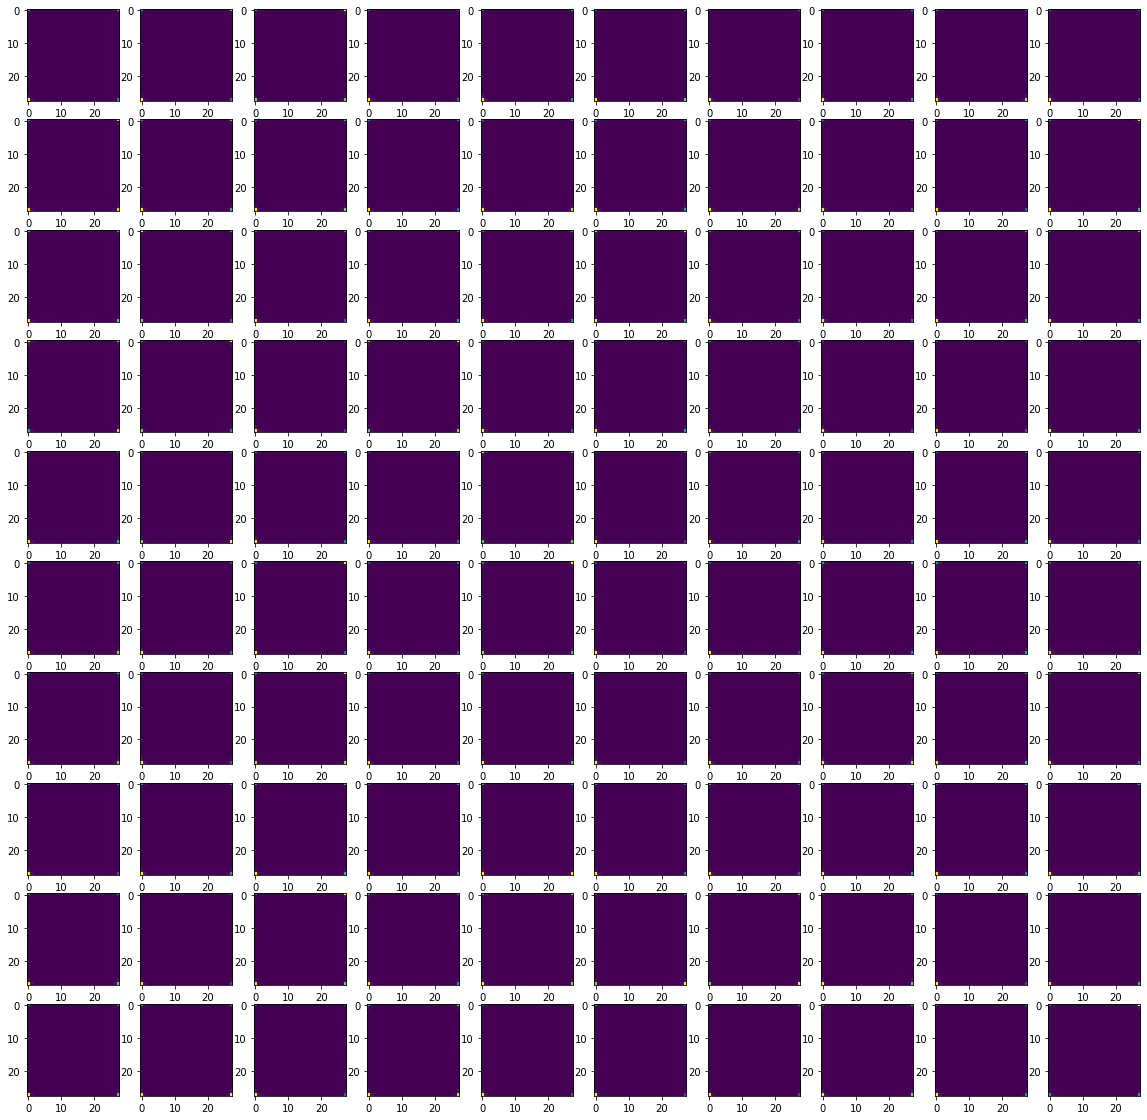

In [140]:
n, m = 10, 10
random_latent_vectors = tf.random.normal(shape=(n*m, latent_dim))
generated_images = gan.generator(random_latent_vectors)

fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(generated_images[n*i+j].numpy().reshape((28, 28)))